In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

In [2]:
# Setting some hyperparameters
batchSize = 64 # We set the size of the batch.
imageSize = 64 # We set the size of the generated images (64x64).

In [3]:
# Creating the transformations
transform = transforms.Compose([transforms.Scale(imageSize), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]) # We create a list of transformations (scaling, tensor conversion, normalization) to apply to the input images.

# Loading the dataset
dataset = dset.CIFAR10(root = './data', download = True, transform = transform) # We download the training set in the ./data folder and we apply the previous transformations on each image.
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 2) # We use dataLoader to get the images of the training set batch by batch.

C:\Users\Indranil\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Files already downloaded and verified


In [4]:
# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
#generator
class G(nn.Module):
    def __init__(self):
        super(G,self).__init__()  #activate inheritance of nn module
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,512,4,1,0,bias=False),#1st inverse convlayer
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512,256,4,2,1,bias=False),#2nd inverse convlayer
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1,bias=False),#3rd inverse convlayer
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1,bias=False),#4th inverse convlayer
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3,4,2,1,bias=False),#last inverse convlayer generate 3 channels
            nn.Tanh() #tangent generate -1 to +1
        )
    def forward(self,input):
        output = self.main(input)
        return output

In [6]:
#create the generator
netG = G().cuda()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [7]:
#define discrimiator
class D(nn.Module):
    def __init__(self):
        super(D,self).__init__()  #activate inheritance of nn module
        self.main = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),#1st convlayer
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,128,4,2,1,bias=False),#2nd convlayer
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(128,256,4,2,1,bias=False),#3rd convlayer
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(256,512,4,2,1,bias=False),#4th convlayer
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(512,1,4,1,0,bias=False),#last convlayer generate 3 channels
            nn.Sigmoid()
        )
    def forward(self,input):
        output = self.main(input)
        return output.view(-1) #flatten the final conv layer
    

In [8]:
#create the discriminator 
netD = D().cuda()
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Training The DCGAN

In [9]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))
dloss=[]
gloss=[]

In [12]:
for epoch in range(25):

    for i, data in enumerate(dataloader, 0):
        
        # 1st Step: Updating the weights of the neural network of the discriminator

        netD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real, _ = data
        input = Variable(real.cuda())
        target = Variable(torch.ones(input.size()[0]).cuda())
        output = netD(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1).cuda())
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0]).cuda())
        output = netD(fake.detach())
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # 2nd Step: Updating the weights of the neural network of the generator

        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]).cuda())
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps

        #print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 25, i, len(dataloader), errD.item(), errG.item()))
        #if i % 100 == 0:
    
    dloss.append(errD.item())
    gloss.append(errG.item())
    print("%d completed.. D_Loss %.4f - G_Loss %.4f" %(epoch+1 ,errD.item(), errG.item()))
    vutils.save_image(real, '%s/real_samples.png' % "./results", normalize = True)
    fake = netG(noise)
    vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize = True)

1 completed.. D_Loss 1.2891 - G_Loss 1.5583
2 completed.. D_Loss 2.2723 - G_Loss 0.2767
3 completed.. D_Loss 0.3151 - G_Loss 4.1601
4 completed.. D_Loss 0.5390 - G_Loss 3.2796
5 completed.. D_Loss 0.7715 - G_Loss 2.5790
6 completed.. D_Loss 0.0966 - G_Loss 3.8564
7 completed.. D_Loss 0.1861 - G_Loss 3.2263
8 completed.. D_Loss 1.6936 - G_Loss 0.0357
9 completed.. D_Loss 1.5144 - G_Loss 5.6654
10 completed.. D_Loss 1.3457 - G_Loss 1.7988
11 completed.. D_Loss 0.2109 - G_Loss 5.4925
12 completed.. D_Loss 0.9676 - G_Loss 1.3108
13 completed.. D_Loss 0.7291 - G_Loss 3.1101
14 completed.. D_Loss 0.0500 - G_Loss 5.5036
15 completed.. D_Loss 0.0007 - G_Loss 7.8437
16 completed.. D_Loss 0.0599 - G_Loss 5.9230
17 completed.. D_Loss 0.3297 - G_Loss 5.4336
18 completed.. D_Loss 0.1425 - G_Loss 3.7009
19 completed.. D_Loss 1.4010 - G_Loss 12.7581
20 completed.. D_Loss 0.2267 - G_Loss 3.0214
21 completed.. D_Loss 0.4695 - G_Loss 1.6746
22 completed.. D_Loss 0.0064 - G_Loss 5.8641
23 completed.. D_L

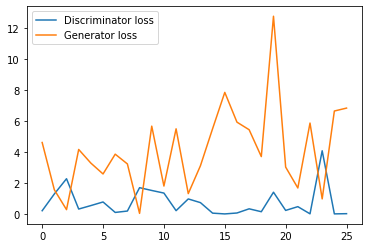

In [14]:
import matplotlib.pyplot as plt
plt.plot(dloss,label='Discriminator loss')
plt.plot(gloss,label='Generator loss')
plt.legend()
plt.show()